In [37]:
using CSV, JuMP, Gurobi, DataFrames, Statistics, PyPlot

In [38]:
GUROBI_ENV = Gurobi.Env();

Academic license - for non-commercial use only


# Reading Data

# IP Formulation

In [39]:
function optimize_lineups(players; nb_lineups=1, max_overlap=6, fp_column="prediction", use_std=false, adj=false, std_column="leaf_std", std_weight = 0.5, MAX_PG=2, MAX_SG=2, MAX_SF=2, MAX_PF=2, MAX_C=1, BUDGET=60000.0, save=true, output_path="../output/lineups.csv")
    # Columns names
    NAME = Symbol("Nickname")
    TEAM = Symbol("Team")
    POSITION = Symbol("Position")
    SALARY = Symbol("Salary")
    INJURY = Symbol("Injury Indicator")
    FP = Symbol(fp_column)
    STD = Symbol(std_column)
    if use_std
        output_columns = [NAME, POSITION, TEAM , FP, STD]
        output_column_names = ["Name_", "Position_", "Team_", "FP_", "STD_"]
    else
        output_columns = [NAME, POSITION, TEAM , FP]
        output_column_names = ["Name_", "Position_", "Team_", "FP_"]
    end 
    
    # Reading inputs
    ## Fantasy points
    fp = players[:,FP];
    ## Positions
    PG = Int.(players[:,POSITION].=="PG")
    SG = Int.(players[:,POSITION].=="SG")
    SF = Int.(players[:,POSITION].=="SF")
    PF = Int.(players[:,POSITION].=="PF")
    C  = Int.(players[:,POSITION].=="C")
    ## Salary
    salary = players[:,SALARY];
    ## Injuries
#     injury = 1 .- ismissing.(players[:,INJURY]) 
#     o_injury = Int.(Missings.coalesce.(players[:,INJURY], 0).=="O")
#     q_injury = Int.(Missings.coalesce.(players[:,INJURY], 0).=="Q")
#     p_injury = Int.(Missings.coalesce.(players[:,INJURY], 0).=="P");

    ## Number of players
    nb_players = size(players)[1]

    # Model
    model = Model(solver=GurobiSolver(OutputFlag=0, GUROBI_ENV))

    # Variable
    @variable(model, z[i=1:nb_players], Bin)

    # Objective function
    if use_std
        ## With std 
        stds = players[:,STD];
        if adj
            @objective(model, Max, sum((fp .+ std_weight.*abs.(stds)).*z))
        else            
            @objective(model, Max, (1-std_weight)*sum(fp.*z) + std_weight*sum(stds.^2 .*z))
        end
    else
        ## Without std        
        @objective(model, Max, sum(fp.*z))
    end
    
    # Constrains without the overleap constraint
    @constraint(model, sum(salary.*z) <= BUDGET)
    @constraint(model, sum(PG.*z) == MAX_PG)
    @constraint(model, sum(SG.*z) == MAX_SG)
    @constraint(model, sum(SF.*z) == MAX_SF)
    @constraint(model, sum(PF.*z) == MAX_PF)
    @constraint(model, sum(C.*z) == MAX_C)
#     @constraint(model, z .<= (1 .- injury))

    # Initialization (iteration=1)
    solve(model)
    x = round.(Int,getvalue(z))
    lineups = players[x.==1, output_columns]    
    names!(lineups, Symbol.(string.(output_column_names, 1)))  

    # Rest of iterations
    @constraint(model, sum(x.*z) <= max_overlap)
    for i=2:nb_lineups
        solve(model)
        x = hcat(x,round.(Int,getvalue(z)))
        lineups_names = players[x[:,i].==1, output_columns]
        names!(lineups_names, Symbol.(string.(output_column_names, i)))    
        lineups = hcat(lineups, lineups_names)
        @constraint(model, sum(x[:,i].*z) <= max_overlap)
    end
    if save
        CSV.write(output_path, lineups);
    end
    score_per_lineup = get_score_lineups(lineups)
    return lineups, score_per_lineup
end;
    

# Annexe functions

In [40]:
function get_number_of_lineups(lineups; fp_column = "FP_")
    # Return the number of lineups using the columns fp_column_i
    colnames = names(lineups)
    nb_lineups = 0
    for col in colnames
        if startswith(string(col), fp_column)
            nb_lineups = nb_lineups+1
        end
    end
    nb_lineups
end;

In [41]:
function get_score_lineups(lineups; fp_column = "FP_")
    # Returns the scores of the lineups based on the columns 
    nb_lineups = get_number_of_lineups(lineups; fp_column = fp_column)
    return aggregate(lineups[:,Symbol.([string(fp_column,i) for i=1:nb_lineups])], sum)
end;

In [42]:
function add_true_scores(lineups, test_set; fp_column = "FP_", true_fp_column = "FP")
    # Adds the columns true_fp_column_i from the test_set to the lineups
    nb_lineups = get_number_of_lineups(lineups; fp_column = fp_column)
    for lineup=1:nb_lineups
        player_names = lineups[!,Symbol(string("Name_",lineup))]
        lineups[!,Symbol(string("True_FP_",lineup))] = filter(row -> row[:Nickname] in player_names, test_set)[!,Symbol(true_fp_column)]
    end
    return order_lineups(lineups)
end;

In [43]:
function order_lineups(lineups)
    # Orders the column of lineups based on the lineup index
    nb_lineups = get_number_of_lineups(lineups)
    colnames = names(lineups)
    ordered_colnames = []
    for lineup=1:nb_lineups
        for col in colnames
            if endswith(string(col), string("_",lineup))
                push!(ordered_colnames, col)
            end
        end
    end
    return lineups[:,ordered_colnames]
end;

In [44]:
function get_lineup(lineups, lineup_idx)
    # Returns all the columns of the lineup with index lineup_idx
    all_colnames = names(lineups)
    lineup_colnames = []
    for col in all_colnames
        if endswith(string(col), string(lineup_idx))
            push!(lineup_colnames, col)
        end
    end
    return lineups[:,lineup_colnames]
end;

In [45]:
function get_best_lineup(lineups; fp_column = "FP_")
    # Returns the best lineup and its score based on the column fp_column_i
    nb_lineups = get_number_of_lineups(lineups)
    scores = get_score_lineups(lineups, fp_column=fp_column)
    best_lineup_idx = 1
    for lineup=2:nb_lineups
        if scores[1,lineup]>scores[1,best_lineup_idx]
            best_lineup_idx=lineup
        end
    end
    return get_lineup(lineups, best_lineup_idx), scores[:,[best_lineup_idx]]
end;

In [46]:
function test_lineups(lineups, test_set; pred_column = "prediction", true_column="FP")
    best_lineup, best_score = optimize_lineups(test_set, fp_column=true_column, nb_lineups=1)
    lineup_with_true_scores = add_true_scores(lineups, test_set; fp_column = "FP_", true_fp_column = true_column)
    best_lineup_with_true_scores, best_lineup_true_score = get_best_lineup(lineup_with_true_scores; fp_column = "True_FP_")
    captured_score = (best_lineup_true_score[1,1]/best_score[1,1])*100
    return captured_score, lineup_with_true_scores, best_lineup, best_lineup_with_true_scores  
end;

# Testing Functions

In [47]:
function generate_paths(suffix)
    paths = DataFrame(keys = String[], 
        optimization_inputs_paths = String[], 
        lineups_output_paths = String[], 
        best_lineup_output_paths = String[], 
        scores_ouput_paths = String[])
    for (root, dirs, files) in walkdir("../data/optimization_inputs/")
        for file in files
            if occursin("_fake", file)
                # Keys
                key = split(file,"_")[1]
                # Paths
                optimization_inputs_path = string("../data/optimization_inputs/",key,"_fake.csv")
                lineups_output_path = string("../data/test_results/",key,"_fake_lineups_",suffix,".csv")
                best_lineup_output_path = string("../data/test_results/",key,"_fake_best_lineup_",suffix,".csv")
                scores_ouputs_path = string("../data/test_results/results_",suffix,".csv")
                push!(paths, [key, optimization_inputs_path, lineups_output_path, best_lineup_output_path, scores_ouputs_path])
            end
        end
    end
    sort!(paths);
    return paths
end;

In [48]:
function run_tests(paths, nb_lineups, max_overlap, use_std; adj=false, std_weight=0.1)
    results = DataFrame(keys = String[], score = Float64[])
    for i=1:size(paths)[1]
#         println(paths[i,:keys])
        key =  paths[i,:keys]
        optimization_inputs_path = paths[i,:optimization_inputs_paths]
        lineups_output_path = paths[i,:lineups_output_paths]
        best_lineup_output_path = paths[i,:best_lineup_output_paths]

        players = CSV.read(optimization_inputs_path);
        try
            lineups, scores = optimize_lineups(players; nb_lineups=nb_lineups, max_overlap=max_overlap, use_std=use_std, adj=adj, std_weight = std_weight, save=false);
            captured_score, lineup_with_true_scores, best_lineup, best_lineup_with_true_scores = test_lineups(lineups, players)
        
            push!(results, [key, captured_score])

            CSV.write(lineups_output_path, lineup_with_true_scores)
            CSV.write(best_lineup_output_path, best_lineup)
        catch InexactError
            println("Unfeasible.")
        end
    end
    CSV.write(paths[1,:scores_ouput_paths], results)
    return results
end;

# function count_positive(results)
#     size(filter(x->x[:score]>=90,results))[1]
    

## Test max_overlap (on the baseline)

In [49]:
nb_lineups = 50
use_std = false
paths = generate_paths("no_std")
max_overlaps_list = [4,5,6,7,8,9]

avg = []
pc1 = []
pc2 = []
for m in max_overlaps
    println(m)
    results = run_tests(paths, nb_lineups, m, use_std)
    println(results)
    sort!(results, 2, rev=true)
    push!(avg, mean(results[!,:score]))
    push!(pc1, size(filter(x->round(Int, x[:score])>=90,results))[1]/size(results)[1])
    push!(pc2, size(filter(x->round(Int, x[:score])>=94,results))[1]/size(results)[1])
end

4
Unfeasible.

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\JuMP\I7whV\src\solvers.jl:212
┌ Warning: Infeasibility ray (Farkas proof) not available
└ @ JuMP C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\JuMP\I7whV\src\solvers.jl:223
┌ Warning: Variable value not defined for component of z. Check that the model was properly solved.
└ @ JuMP C:\Users\iai\builds\InterpretableAI\SysImgBuilder\.julia\packages\JuMP\I7whV\src\JuMP.jl:480



13×2 DataFrame
│ Row │ keys       │ score   │
│     │ String     │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 2012-01-14 │ 83.875  │
│ 2   │ 2012-03-01 │ 79.8427 │
│ 3   │ 2013-03-05 │ 93.5193 │
│ 4   │ 2013-10-30 │ 87.5366 │
│ 5   │ 2013-11-17 │ 88.2806 │
│ 6   │ 2014-01-11 │ 84.5311 │
│ 7   │ 2014-02-11 │ 82.2522 │
│ 8   │ 2014-03-12 │ 86.421  │
│ 9   │ 2015-01-11 │ 85.6261 │
│ 10  │ 2015-02-24 │ 86.7499 │
│ 11  │ 2015-03-13 │ 77.4324 │
│ 12  │ 2015-04-11 │ 78.0754 │
│ 13  │ 2015-11-27 │ 84.5553 │
5
14×2 DataFrame
│ Row │ keys       │ score   │
│     │ String     │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 2012-01-14 │ 84.6008 │
│ 2   │ 2012-03-01 │ 81.5613 │
│ 3   │ 2013-03-05 │ 94.3958 │
│ 4   │ 2013-10-30 │ 84.0945 │
│ 5   │ 2013-11-17 │ 89.8762 │
│ 6   │ 2014-01-11 │ 82.952  │
│ 7   │ 2014-02-11 │ 80.7331 │
│ 8   │ 2014-03-12 │ 84.6154 │
│ 9   │ 2015-01-11 │ 80.9089 │
│ 10  │ 2015-02-24 │ 83.5415 │
│ 11  │ 2015-03-13 │ 81.7791 │
│ 12  │ 2015-04-11 │ 80.4131 │
│ 13  

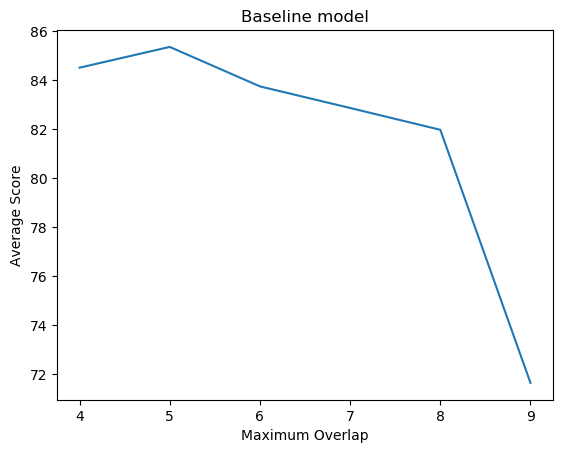

PyObject Text(24.000000000000007, 0.5, 'Average Score')

In [99]:
p = plt.plot(max_overlaps, avg)
plt.title("Baseline model")
plt.xlabel("Maximum Overlap")
plt.ylabel("Average Score")

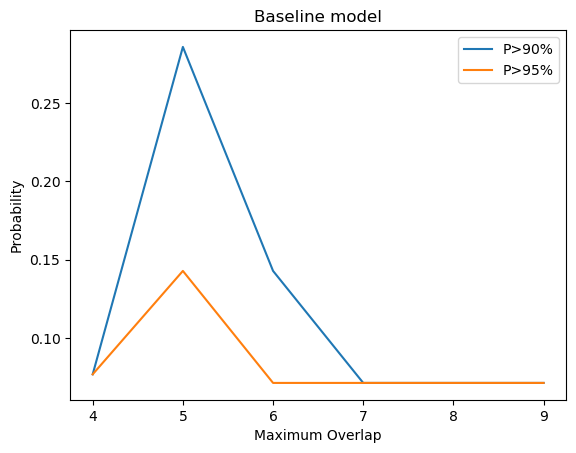

PyObject <matplotlib.legend.Legend object at 0x0000000004AAE3C8>

In [100]:
p1 = plt.plot(max_overlaps, pc1, label="P>90%")
p2 = plt.plot(max_overlaps, pc2, label="P>95%")
plt.title("Baseline model")
plt.xlabel("Maximum Overlap")
plt.ylabel("Probability")
plt.legend()

## Testing number of lineups (Baseline)

In [96]:
nb_lineups_list = [20:5:50;]
max_overlap = 5
use_std = false
paths = generate_paths("no_std")

avg_2 = []
pc1_2 = []
pc2_2 = []
for n in nb_lineups_list
    println(n)
    results = run_tests(paths, n, max_overlap, use_std)
    println(results)
    sort!(results, 2, rev=true)
    push!(avg_2, mean(results[!,:score]))
    push!(pc1_2, size(filter(x->round(Int, x[:score])>=90,results))[1]/size(results)[1])
    push!(pc2_2, size(filter(x->round(Int, x[:score])>=94,results))[1]/size(results)[1])
end

20
14×2 DataFrame


InterruptException: InterruptException:

In [97]:
p_2 = plt.plot(nb_lineups_list, avg_2)
plt.title("Baseline model")
plt.xlabel("Number of Lineups")
plt.ylabel("Average Score")

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\enysb\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (7,) and (0,)',)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2795, in plot
    is not None else {}), **kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 225, in __call__
    yield from self._plot_args(this, kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 391, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 270, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


In [82]:
p1_2 = plt.plot(nb_lineups_list, pc1_2, label="P>90%")
p2_3 = plt.plot(nb_lineups_list, pc2_2, label="P>95%")
plt.title("Baseline model")
plt.xlabel("Number of Lineups")
plt.ylabel("Probability")
plt.legend()

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\enysb\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (1,) and (7,)',)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2795, in plot
    is not None else {}), **kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 225, in __call__
    yield from self._plot_args(this, kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 391, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 270, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


## Testing rho (variance)

In [55]:
nb_lineups = 50
max_overlap = 5
use_std = true
var_weight_list = [0:0.2:1;]

paths_1 = generate_paths("with_var")

avg_3 = []
pc1_3 = []
pc2_3 = []
for std in var_weight_list
    println(std)
    results = run_tests(paths_1, nb_lineups, max_overlap, use_std; std_weight=std)
    println(results)
    sort!(results, 2, rev=true)
    push!(avg_3, mean(results[!,:score]))
    push!(pc1_3, size(filter(x->round(Int, x[:score])>=90,results))[1]/size(results)[1])
    push!(pc2_3, size(filter(x->round(Int, x[:score])>=94,results))[1]/size(results)[1])
end

0.0
14×2 DataFrame
│ Row │ keys       │ score   │
│     │ String     │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 2012-01-14 │ 84.6008 │
│ 2   │ 2012-03-01 │ 81.5613 │
│ 3   │ 2013-03-05 │ 94.3958 │
│ 4   │ 2013-10-30 │ 84.0945 │
│ 5   │ 2013-11-17 │ 89.8762 │
│ 6   │ 2014-01-11 │ 82.952  │
│ 7   │ 2014-02-11 │ 80.7331 │
│ 8   │ 2014-03-12 │ 84.6154 │
│ 9   │ 2015-01-11 │ 80.9089 │
│ 10  │ 2015-02-24 │ 83.5415 │
│ 11  │ 2015-03-13 │ 81.7791 │
│ 12  │ 2015-04-11 │ 80.4131 │
│ 13  │ 2015-05-11 │ 95.6286 │
│ 14  │ 2015-11-27 │ 89.9864 │
0.2
14×2 DataFrame
│ Row │ keys       │ score   │
│     │ String     │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 2012-01-14 │ 88.1666 │
│ 2   │ 2012-03-01 │ 79.7262 │
│ 3   │ 2013-03-05 │ 89.7211 │
│ 4   │ 2013-10-30 │ 88.7514 │
│ 5   │ 2013-11-17 │ 86.9326 │
│ 6   │ 2014-01-11 │ 82.7264 │
│ 7   │ 2014-02-11 │ 76.6337 │
│ 8   │ 2014-03-12 │ 83.5023 │
│ 9   │ 2015-01-11 │ 77.303  │
│ 10  │ 2015-02-24 │ 85.8437 │
│ 11  │ 2015-03-13 │ 74.8294 │
│

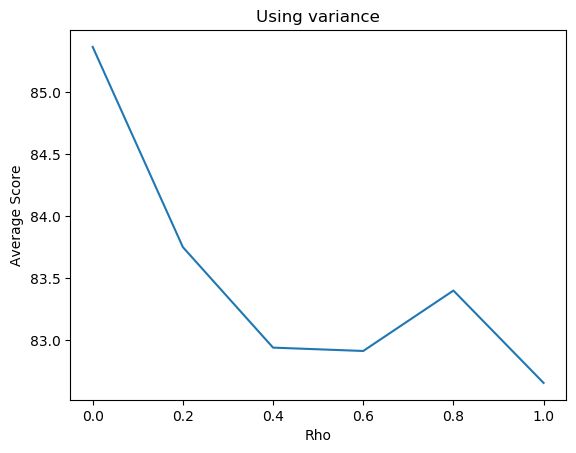

PyObject Text(24.000000000000007, 0.5, 'Average Score')

In [92]:
p_3 = plt.plot(var_weight_list, avg_3)
plt.title("Using variance")
plt.xlabel("Rho")
plt.ylabel("Average Score")

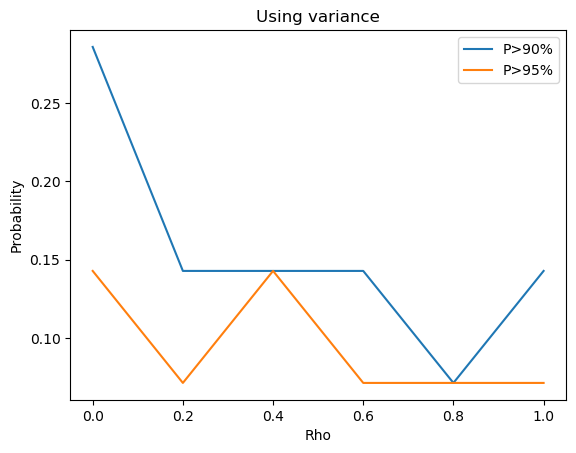

PyObject <matplotlib.legend.Legend object at 0x0000000004B1EEF0>

In [93]:
p1_3 = plt.plot(var_weight_list, pc1_3, label="P>90%")
p2_3 = plt.plot(var_weight_list, pc2_3, label="P>95%")
plt.title("Using variance")
plt.xlabel("Rho")
plt.ylabel("Probability")
plt.legend()

## Testing lambda (boosted prediction)

In [58]:
std_weight_list = [0:0.2:1;]
nb_lineups = 50
max_overlap = 5
use_std = true
adj = true

paths_2 = generate_paths("with_std_adj")

avg_4 = []
pc1_4 = []
pc2_4 = []
for std in std_weight_list
    println(std)
    results = run_tests(paths_2, nb_lineups, max_overlap, use_std; adj=adj, std_weight=std)
    println(results)
    sort!(results, 2, rev=true)
    push!(avg_4, mean(results[!,:score]))
    push!(pc1_4, size(filter(x->round(Int, x[:score])>=90,results))[1]/size(results)[1])
    push!(pc2_4, size(filter(x->round(Int, x[:score])>=94,results))[1]/size(results)[1])
end

0.0
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
0×2 DataFrame

0.2
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
0×2 DataFrame

0.4
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
0×2 DataFrame

0.6
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
0×2 DataFrame

0.8
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
0×2 DataFrame

1.0
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
Unfeasible.
U

In [59]:
p_4 = plt.plot(std_weight_list, avg_4)
plt.title("Using variance")
plt.xlabel("Lambda")
plt.ylabel("Average Score")

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\enysb\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (1,) and (6,)',)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2795, in plot
    is not None else {}), **kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 1666, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 225, in __call__
    yield from self._plot_args(this, kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 391, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_base.py", line 270, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))


In [85]:
p1_4 = plt.plot(std_weight_list, pc1_4, label="P>90%")
p2_4 = plt.plot(std_weight_list, pc2_4, label="P>95%")
plt.title("Using variance")
plt.xlabel("Lambda")
plt.ylabel("Probability")
plt.legend(handles=[p1, p2])

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\enysb\.julia\packages\PyCall\ttONZ\src\pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError("'list' object has no attribute 'get_label'",)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\pyplot.py", line 2691, in legend
    return gca().legend(*args, **kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\axes\_axes.py", line 403, in legend
    **kwargs)
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\legend.py", line 1271, in _parse_legend_args
    labels = [handle.get_label() for handle in handles]
  File "C:\Users\enysb\.julia\conda\3\lib\site-packages\matplotlib\legend.py", line 1271, in <listcomp>
    labels = [handle.get_label() for handle in handles]


### Baseline

In [61]:
# nb_lineups = 50
# max_overlap = 5
# use_std = false

# paths = generate_paths("no_std")
# results = run_tests(paths, nb_lineups, max_overlap, use_std)
# sort!(results, 2, rev=true)

In [62]:
# mean(results[,:score])

In [63]:
# size(filter(x->round(Int, x[:score])>=90,results))[1]/size(results)[1]

In [64]:
# size(filter(x->round(Int, x[:score])>=95,results))[1]/size(results)[1]

### Not adjusted

In [65]:
# nb_lineups = 50
# max_overlap = 5
# use_std = true
# std_weight = 0.2

# paths_1 = generate_paths("with_std")
# results_1 = run_tests(paths_1, nb_lineups, max_overlap, use_std; std_weight=std_weight)
# sort!(results_1, 2, rev=true)

In [66]:
# mean(results_1[:,:score])

In [67]:
# size(filter(x->round(Int, x[:score])>=90,results_1))[1]/size(results_1)[1]

In [68]:
# size(filter(x->round(Int, x[:score])>=95,results_1))[1]/size(results_1)[1]

### Adjusted

In [69]:
# nb_lineups = 50
# max_overlap = 5
# use_std = true
# adj = true
# std_weight = 1

# paths_2 = generate_paths("with_std_adj")
# results_2 = run_tests(paths_2, nb_lineups, max_overlap, use_std; adj=adj, std_weight=std_weight)
# sort!(results_2, 2, rev=true)

In [70]:
# mean(results_2[1:14,:score])

In [71]:
# size(filter(x->round(Int, x[:score])>=90,results_2))[1]/size(results_2)[1]

In [72]:
# size(filter(x->round(Int, x[:score])>=95,results_2))[1]/size(results_2)[1]